# plotting routines

In [ ]:
def sort_info_df(info, metric):
    N = info.shape[0]
    strains = {}
    for strain in info['Strain']:
        strains[strain] = []
        
    for i in range(N):
        data = info.iloc[i]
        strains[data['Strain']].append(data[metric])
    
    for key, value in strains.items():
        strains[key] = sum(value)/len(value)
    
    strains = dict(sorted(strains.items(), key=lambda item: item[1]))
    return strains.keys()

def plot_mean_std(info, strain, idx, metric, ax):
    rect_width = 0.5
    strain_data = info.loc[info['Strain'] == strain, metric]
    rect_height, mean = strain_data.std(), strain_data.mean()

    rect_bottom_left = (idx - (rect_width / 2), max(mean - rect_height, 0))
    if mean - rect_height < 0:
        rect_size = (rect_width, mean)
    else:
        rect_size = (rect_width, rect_height)
    ax.add_patch(plt.Rectangle(rect_bottom_left, *rect_size, edgecolor='k', linewidth=1.2, fill=False, zorder=1000))

    rect_bottom_left = (idx - (rect_width / 2), mean)
    rect_size = (rect_width, rect_height)
    ax.add_patch(plt.Rectangle(rect_bottom_left, *rect_size, edgecolor='k', linewidth=1.2, fill=False, zorder=1000))
    
def plot_behaviour_metric(info, metric, order, ylabel=None):        
    ylabel = metric if ylabel is None else ylabel
    fig = plt.figure()
    g = sns.catplot(x='Strain', y=metric, data=info, hue='Sex', jitter=False, legend=False, order=order, ci=0.95)
    ax = g.axes[0,0]
    ax.tick_params(grid_color='gray', grid_alpha=0.3, labelrotation=90, labelsize=8)
    ax.grid(True)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(None, fontsize=12)
    ax.legend(loc='upper left', title='Sex', borderpad=0.5)
    plt.gcf().set_size_inches(10, 2.2)
    return fig, ax

def plot_all_metrics_for_behaviour(behaviour_stats, behaviour, ylimits):
    stats = behaviour_stats[behaviour]
    info = pd.DataFrame.from_dict(stats)
    info['Total Duration'] = info['Total Duration']/60

    metrics = ['Total Duration', 'Average Bout Length', 'No. of Bouts']
    labels = ['Total Duration (min)', 'Average Bout Length (s)', 'No. of Bouts']
    save_names  = ['TD', 'ABL', 'NB']

    figs = []
    for i in range(len(metrics)):
        strains = list(sort_info_df(info, metrics[i]))
        fig, ax = plot_behaviour_metric(info, metrics[i], strains, labels[i])

        for j in range(len(strains)):
            plot_mean_std(info, strains[j], j, metrics[i], ax)
        
        ax.tick_params(axis='y', labelrotation=0, labelsize=8)
        if ylimits[metrics[i]] is not None:
            ax.set_ylim(ylimits[metrics[i]])
        behaviour = behaviour.replace('/', '-')
        sns.despine(trim=True)
        plt.savefig(f'{plot_dir}/{save_names[i]}_{behaviour}', dpi=500, bbox_inches='tight')
        figs.append(fig)
    
    return figs

In [ ]:
ylimits = {
    'Groom'    : {'Total Duration': None, 'Average Bout Length': None, 'No. of Bouts': None},
    'Run'      : {'Total Duration': None, 'Average Bout Length': None, 'No. of Bouts': None},
    'Walk'     : {'Total Duration': None, 'Average Bout Length': [0, 1.5], 'No. of Bouts': None},
    'CW-Turn'  : {'Total Duration': None, 'Average Bout Length': None, 'No. of Bouts': None},
    'CCW-Turn' : {'Total Duration': None, 'Average Bout Length': None, 'No. of Bouts': None},
    'Point'    : {'Total Duration': [0, 20], 'Average Bout Length': [0, 20], 'No. of Bouts': [0, 1200]},
    'Rear'     : {'Total Duration': None, 'Average Bout Length': [0, 2], 'No. of Bouts': None},
    'N/A'      : {'Total Duration': None, 'Average Bout Length': None, 'No. of Bouts': None}
}

grouped_stats = group_stats(behaviour_stats)
for behaviour in BEHAVIOUR_LABELS.keys():
    figs = plot_all_metrics_for_behaviour(grouped_stats, behaviour, ylimits[behaviour])

# plot behaviour distribution for all data

In [ ]:
import numpy as np
from analysis import *
from BSOID.bsoid import BSOID

usage = calculate_behaviour_usage(label_info_file)

In [ ]:
def sort_usage_info(info):
    N = info.shape[0]
    behaviours = {}
    for behaviour in info['Behaviour']:
        behaviours[behaviour] = []
        
    for i in range(N):
        data = info.iloc[i]
        behaviours[data['Behaviour']].append(data['Usage'])
    
    for key, value in behaviours.items():
        value = np.array(value)
        behaviours[key] = [value.mean(), value.std()]
    
    behaviours = dict(sorted(behaviours.items(), key=lambda item: item[1][0], reverse=True))
    return behaviours
    
sorted_usage = sort_usage_info(usage)

x, mean_usage, std_usage = [], [], []
for key, val in sorted_usage.items():
    x.append(key)
    mean_usage.append(val[0])
    std_usage.append(val[1])

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.errorbar(x=x, y=mean_usage, yerr=std_usage, fmt='-k', ecolor=(0.59, 0.59, 0.61, 0.7), elinewidth=5, linewidth=3)
ax.set_xlabel('Sorted Behaviours')
ax.set_ylabel('Proportion Usage')
sns.despine(trim=True)
ax.tick_params(axis='x', labelrotation=90)
plt.savefig(f'{plot_dir}/prop.png', dpi=600, bbox_inches='tight')
fig.show()

# Show proportion of behaviour used for each strain
----

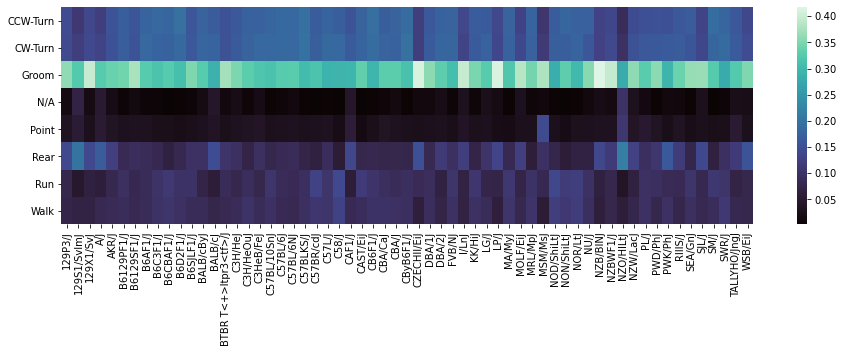

In [4]:
usage_data = behaviour_usage_across_strains(label_info_file)
usage_datamat = usage_data.pivot_table(index='Behaviour', columns='Strain', values='Usage')

ax = sns.heatmap(usage_datamat, xticklabels=True, yticklabels=True, cmap='mako')
plt.gcf().set_size_inches(15.5, 4)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig(f'{plot_dir}/usage.png', dpi=600, bbox_inches='tight')
plt.show() 

# Plot transition network

In [3]:
def tnet_from_tmat(tmat, behaviour_usage, diff_graph=False):        
    if diff_graph:
        bins = [-0.1, -0.05, -0.025, 0, 0.025, 0.05, 0.1]
    else:
        bins = [0, 0.025, 0.075, 0.15]

    for i in range(tmat.shape[0]):
        tmat[i,i] = -1

    G = nx.MultiDiGraph()
    G.add_nodes_from(range(0, tmat.shape[0]))

    not_allowed = [0] if not diff_graph else [3, 4]
    for i in range(tmat.shape[0]):
        for j in range(tmat.shape[1]):
            tmat[i,j] = abs(tmat[i,j])
            if i != j:
                bin_idx = bin_wts(tmat[i,j], bins)
                if bin_idx not in not_allowed:
                    G.add_edge(i, j, weight=tmat[i,j])
    if diff_graph:
        edge_wts = [5, 1, 0.2, 0, 0, 0.2, 1, 5]
    else:
        edge_wts = [0, 0.2, 1, 5]
    widths = [edge_wts[bin_wts(G[u][v][0]['weight'], bins)] for u, v in G.edges()]
    return G, widths, bins

def bin_wts(wt, bins):
    if bins[0] >= 0:
        for i in range(len(bins)-1):
            if wt >= bins[i] and wt < bins[i+1]:
                return i
        return len(bins) - 1
    else:
        if wt < bins[0]:
            return 0
        for i in range(0, len(bins)-1):
            if wt >= bins[i] and wt < bins[i+1]:
                return i + 1
        return len(bins)

def get_usage_for_strain(label_info_file, strain=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
    usage_data = Parallel(n_jobs=-1)(delayed(behaviour_proportion)(labs) for labs in labels)
#     usage_data = np.vstack([behaviour_proportion(labs, max_label) for labs in labels])
    usage_data = np.vstack(usage_data)
    usage_data = usage_data.sum(axis=0)/usage_data.shape[0]
    return usage_data
    
def get_tmat_for_strain(label_info_file, strain=None):
    with open(label_info_file, 'rb') as f:
        label_info = joblib.load(f)
    N = len(label_info['Strain'])
    
    if strain is not None:
        labels = [label_info['Labels'][i] for i in range(N) if label_info['Strain'][i] == strain]
    else:
        labels = label_info['Labels']
    del label_info
    
#     tmat_data = [transition_matrix_from_assay(labs, max_label) for labs in labels]
    tmat_data = Parallel(n_jobs=-1)(delayed(transition_matrix_from_assay)(labs) for labs in labels)
            
    tmat = tmat_data[0]
    for i in range(1, len(tmat_data)):
        tmat += tmat_data[i]
    
    tmat = tmat / len(tmat_data)
    return tmat

In [ ]:
tmat = get_tmat_for_strain(label_info_file, max_label=19)
usage = behaviour_usage_for_strain(label_info_file, max_label=19)

In [ ]:
G, widths = tnet_from_tmat(tmat, usage)

color = tuple([ x / 255 for x in [18 ,63, 161 ,0.65 * 255]])
nx.draw_spectral(G, node_size=2000*usage, connectionstyle='bar, fraction = 0.01', edge_color=color, edgecolors='k', node_color='white', width=widths, arrowsize=5)
plt.show()

# Change in Transitions

In [ ]:
strain1, strain2 = 'C57BL/6J', 'NZO/HILtJ'
usage1 = get_usage_for_strain(label_info_file, strain1)
usage2 = get_usage_for_strain(label_info_file, strain2)
tmat1 = get_tmat_for_strain(label_info_file, strain1)
tmat2 = get_tmat_for_strain(label_info_file, strain2)

In [ ]:
strain1, strain2 = strain1.replace('/', '-'), strain2.replace('/', '-')
d_tmat = tmat2 - tmat1
neg_color = tuple([x / 255 for x in [189, 27, 15, 0.85 * 255]])
pos_color = tuple([x / 255 for x in [18 ,63, 161 ,0.85 * 255]])

G1, widths1, bins1 = tnet_from_tmat(tmat1, usage1)
G2, widths2, bins2 = tnet_from_tmat(x, usage2)
pos = nx.spectral_layout(G1)

nx.draw(G1, pos=pos, node_size=2000*usage1, connectionstyle='bar, fraction = 0.01', edge_color=pos_color, edgecolors='k', node_color='white', width=widths1, arrowsize=5)

import matplotlib.patches as mpatches
pos_color = list(pos_color)
pos_color[-1] = 1.0
# labels = ['10%', '5%', '1%']
labels = [f'{round(x * 100, 1)}%' for x in bins1[1:][::-1]]
sizes = [5, 1, 0.2]
correction = [0.5, 2.75, 3.5]
patches = [mpatches.Patch(color=pos_color, label=lab) for lab in labels]
leg = plt.legend(handles=patches, bbox_to_anchor=(0.02, 1.05), loc='upper left', labelspacing=0.25, frameon=False, 
title='Transition\nProbability', prop={'size': 12})
plt.setp(leg.get_title(), fontsize=12)
for i, patch in enumerate(leg.get_patches()):
    patch.set_height(sizes[i])
    patch.set_y(correction[i])
plt.savefig(f'{plot_dir}/{strain1}_map.png', dpi=600, bbox_inches='tight')
plt.show()

nx.draw(G2, pos=pos, node_size=2000*usage2, connectionstyle='bar, fraction = 0.01', edge_color=pos_color, edgecolors='k', node_color='white', width=widths2, arrowsize=5)
plt.savefig(f'{plot_dir}/{strain2}_map.png', dpi=600, bbox_inches='tight')
plt.show()

diff_usage = usage2 - usage1
diff_G, widths3, bins3 = tnet_from_tmat(d_tmat, np.abs(diff_usage), diff_graph=True)
node_colors = []
for i in range(diff_usage.shape[0]):
    if diff_usage[i] < 0:
        node_colors.append(neg_color)
    else:
        node_colors.append(pos_color)
edge_colors = []
for u, v in diff_G.edges():
    if diff_G[u][v][0]['weight'] >= 0:
        edge_colors.append(pos_color)
    else:
        edge_colors.append(neg_color)
nx.draw(diff_G, pos=pos, node_size=2000*usage1, connectionstyle='bar, fraction = 0.01', edge_color=edge_colors, edgecolors=node_colors, node_color='white', width=widths3, arrowsize=5)

import matplotlib.patches as mpatches
colors = [pos_color, pos_color, neg_color, neg_color]
colors = [list(c) for c in colors]
for c in colors:
    c[-1] = 1.0

# labels = [r'$+5.0\%$', r'$+2.5\%$', r'$-2.5\%$', r'$-5.0\%$']
bins3 = np.hstack((bins3[5:][::-1], bins3[0:2][::-1]))
labels = [f'{round(x * 100, 1)}%' for x in bins3]
sizes = [5, 1, 1, 5]
correction = [0.5, 1.2, 1.7, 0.85]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
leg = plt.legend(handles=patches, bbox_to_anchor=(-0.04, 1.05), loc='upper left', labelspacing=0.25, frameon=False, 
title='Transition\nProbability', prop={'size': 12})
plt.setp(leg.get_title(),fontsize=12)
for i, patch in enumerate(leg.get_patches()):
    patch.set_height(sizes[i])
    patch.set_y(correction[i])

plt.savefig(f'{plot_dir}/diff.png', dpi=600, bbox_inches='tight')
plt.show()

# Plotting feature vs. time

In [ ]:
from BSOID.bsoid import BSOID
bsoid = BSOID.load_config(run_id='dis', base_dir='D:/IIT/DDP/data')
_, _, umap_embeddings = bsoid.load_umap_results()
assignments, _, soft_assignments, best_clf = bsoid.load_identified_clusters()

In [ ]:
X, labels = umap_embeddings[assignments >= 0], soft_assignments[assignments >= 0]

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
colors = np.array([cmap(idx/labels.max()) for idx in labels])

ax.scatter(X[:,0], X[:,1], X[:,2], c=colors, s=0.1, alpha=0.2)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')


leg_labels = [None for _ in range(soft_assignments.max()+1)]
for key, val in BEHAVIOUR_LABELS.items():
    if len(val) > 1:
        for i, idx in enumerate(val):
            leg_labels[idx] = f'{key} #{i}'
    else:
        leg_labels[val[0]] = key

lines = [Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=cmap(idx/labels.max())) for i in range(labels.max() + 1)]
plt.legend(lines, leg_labels, loc='upper right')

plt.show()

In [ ]:
t_max = 3
t = np.arange(3 * FPS) * 1000 // FPS

auto_corr = np.load('./auto_corr.npy')
auto_corr = np.reshape(auto_corr, (-1, t.shape[0]))

idx = np.where(auto_corr[:,11] <= 0.4)[0]
auto_corr = auto_corr[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(auto_corr.shape[0]):
    ax.plot(t, auto_corr[i], color=(0.46, 0.46, 0.46, 0.2))

auto_corr = auto_corr.mean(axis=0)
ax.plot(t, auto_corr, color='black', linewidth=2)

ax.set_xlabel('Time Lag (ms)', fontsize=12)
ax.set_ylabel('Auto-correlation', fontsize=12)
sns.despine(trim=True)
plt.show()

# Hinton Diagram for Transition Probabilities

In [6]:
tmat = get_tmat_for_strain(label_info_file)

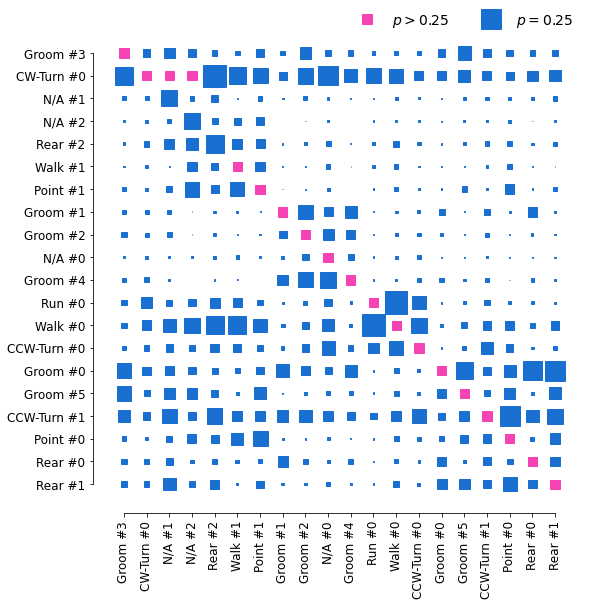

In [7]:
def hinton(matrix, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    # if not max_weight:
    #     max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    # ax.xaxis.set_major_locator(plt.NullLocator())
    # ax.yaxis.set_major_locator(plt.NullLocator())

    max_weight = 0.25
    for (x, y), w in np.ndenumerate(matrix):
        color = (0.1, 0.44, 0.82)
        if w > max_weight:
            color = (0.96, 0.26, 0.71)
            w = max_weight / 6
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

    sz = 20
    b1, = ax.plot([], marker='s', markersize=9.5, linestyle='', color = (0.96, 0.26, 0.71), label=r'$p > 0.25$')
    b2, = ax.plot([], marker='s', markersize=sz, linestyle='', color=(0.1, 0.44, 0.82), label=r'$p = 0.25$')

    leg = plt.legend(handles=[b1, b2], bbox_to_anchor=(0.5, 1.05), loc='upper left', prop={'size': 14}, ncol=2)
    leg.get_frame().set_linewidth(0.0)
    return ax

from sklearn.cluster import SpectralClustering
labels = SpectralClustering(affinity='precomputed', n_clusters=4).fit_predict(tmat)
spectral_tmat = np.zeros_like(tmat)

groups = [[] for x in range(labels.max()+1)]
for i, x in enumerate(labels):
    groups[x].append(i)

idx_labels, new_idx_map, i = [], {}, 0
for g in groups:
    for idx in g:
        idx_labels.append(idx_2_behaviour(idx, diff=True))
        new_idx_map[idx] = i
        i += 1

for i, g in enumerate(groups):
    for idx1 in g:
        for idx2 in g:
            spectral_tmat[new_idx_map[idx1], new_idx_map[idx2]] = tmat[idx1, idx2]
    
    for j, h in enumerate(groups):
        if i != j:
            for idx1 in g:
                for idx2 in h:
                    spectral_tmat[new_idx_map[idx1], new_idx_map[idx2]] = tmat[idx1, idx2]

# sns.heatmap(spectral_tmat, xticklabels=idx_labels, yticklabels=idx_labels, cam)
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
plt.xticks(np.arange(20), idx_labels, rotation=90, fontsize=12)
plt.yticks(np.arange(20), idx_labels, rotation=0, fontsize=12)
hinton(spectral_tmat, ax=ax)
sns.despine(trim=True)
plt.savefig(f'{plot_dir}/tmat.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
max_strain = usage_datamat.loc[usage_datamat.index == behaviour]
max_strain = max_strain.idxmax(axis=1)[0]

strain_usage = usage_data.loc[(usage_data['Strain'] == max_strain) & (usage_data['Behaviour'] == behaviour), 'Usage']
print(strain_usage.mean(), strain_usage.std())

b_usage = usage_datamat.loc[usage_datamat.index == behaviour].iloc[0]
print(b_usage.mean(), b_usage.std())
max_strain

# PVE

In [ ]:
pve = calculate_PVE(behaviour_stats, metric='Total Duration')

In [ ]:
 def plot_pve_estimates(pve: dict):
    width=1.0

    pve_data, labels = [], []
    for lab, data in pve.items():
        labels.append(lab)
        pve_data.append(list(data))
    pve_data = np.array(pve_data)
    
    idx = (-pve_data).argsort(axis=0)[:-1,0]
    y_pos = np.arange(idx.size)
    labels, pve_data = [labels[i] for i in idx], pve_data[idx]

    i, groups = 0, {}
    for lab in labels:
        if lab[:-3] not in groups:
            groups[lab[:-3]] = i
            i += 1
    cmap = mpl.cm.get_cmap('Set2')
    colors = [cmap(groups[lab[:-3]]) for lab in labels]

    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    ax.barh(y=y_pos, 
            width=pve_data[:,0], 
            xerr=pve_data[:,1], 
            align='edge', 
            height=width, 
            edgecolor='k', 
            linewidth=2.5, 
            error_kw={'elinewidth': 2.5, 'capsize': 3.0},
            color=colors
        )
    
    import matplotlib.patches as mpatches
    legend_items = [mpatches.Patch(color=cmap(c), label=lab) for lab, c in groups.items()]
    plt.legend(handles=legend_items, loc='upper right', prop={'size': 15}, frameon=False)

    ax.set_xlim([0, 0.5])
    ax.set_ylim([0, idx.size])
    ax.set_yticks(y_pos + 0.5)
    ax.set_xlabel('PVE', fontsize=18)
    ax.set_ylabel('Phenotype', fontsize=18)
    ax.set_yticklabels(labels)

    sns.despine()
    plt.savefig(f'{plot_dir}/pve.png', dpi=600, bbox_inches='tight')
    plt.show()

plot_pve_estimates(pve)

# Scatter plot for strains

In [ ]:
strains_file = './strains_to_include_in_scatter_plot.txt'
strains = [l.strip() for l in open(strains_file, 'rb').readlines()]

for strain in strains:

In [4]:
import matplotlib.pyplot as plt
import umap

import sys
sys.path.insert(0, "/Users/dhruvlaad/IIT/DDP/DDP/B-SOID/")
from analysis import *

In [23]:
label_info_file = "../../../data/analysis/label_info.pkl"
with open(label_info_file, "rb") as f:
    label_info = joblib.load(f)
tvec = Parallel(n_jobs=-1)(delayed(transition_matrix_from_assay)(lab) for lab in label_info["Labels"])

In [33]:
drop_idx = BEHAVIOUR_LABELS["N/A"] + BEHAVIOUR_LABELS["Point"]
idx = [i for i in range(tvec[0].shape[0]) if i not in drop_idx]
tvec_dropped = [t[idx][:,idx].flatten() for t in tvec]

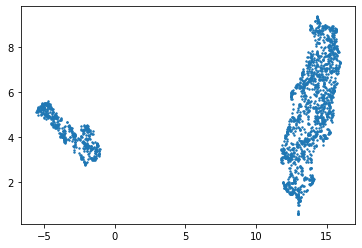

In [37]:
x = umap.UMAP(min_dist=0.0).fit_transform(tvec_dropped)
plt.scatter(x[:,0], x[:,1], s=2)
plt.show()

In [50]:
import hdbscan
T = sum(tvec)/len(tvec)
labels = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=2).fit_predict(T)